In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import label

# Paths to your files
image_path = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28\signals\image_00002.jpg"
gt_path = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data_2_traces\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-28\ground_truth\sample_00002.npy"

# Load image as grayscale and convert to float32
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
image = image.max() - image  # Invert the image

# Load ground truth as a NumPy array
gt = np.load(gt_path)  # shape: (2, width)

# crop
# image = image[:, :200]
# gt = gt[:, :200]

# Confirm shapes
print("Image shape:", image.shape)   # (height, width)
print("Ground truth shape:", gt.shape)  # (2, width)


Image shape: (400, 800)
Ground truth shape: (2, 800)


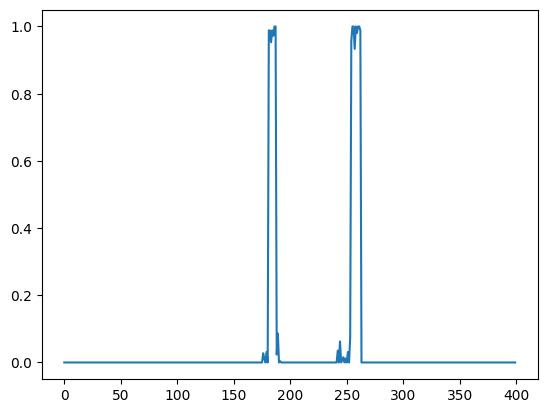

In [2]:
plt.plot(image[:, 50])

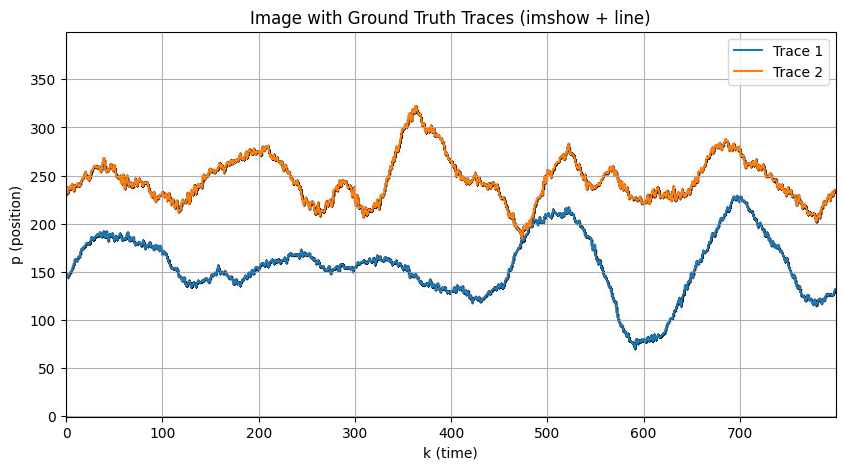

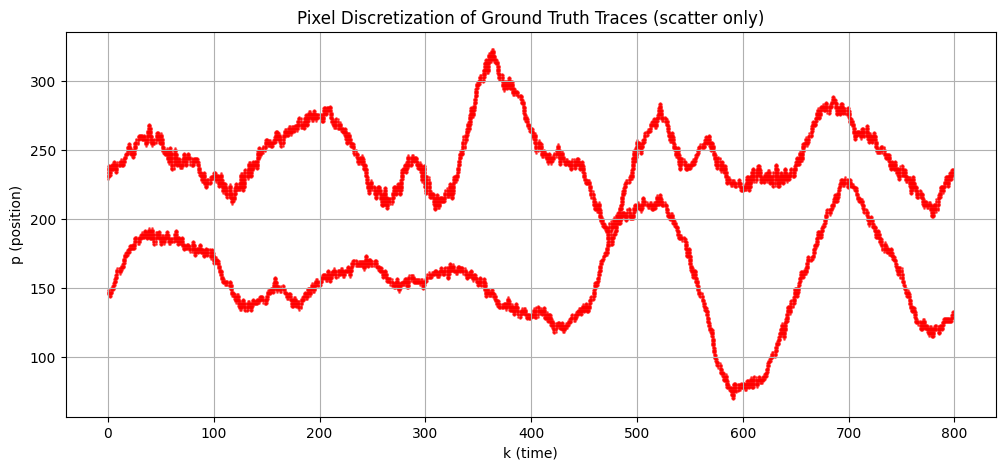

In [3]:
# First figure: imshow + GT curves
plt.figure(figsize=(12, 5))
plt.imshow(image.max()-image, cmap='gray', origin='lower')
for i in range(gt.shape[0]):
    plt.plot(gt[i], label=f'Trace {i+1}', linewidth=1.5)
plt.title("Image with Ground Truth Traces (imshow + line)")
plt.xlabel("k (time)")
plt.ylabel("p (position)")
plt.legend()
plt.grid(True)
plt.show()

# Second figure: scatter-only pixel representation
plt.figure(figsize=(12, 5))
for k in range(len(gt[0])):
    col = np.where(image[:, k] > 0.5)[0]
    if len(col) > 0:
        plt.scatter(k*np.ones_like(col), col, s=1, color='red', alpha=0.6)  
plt.title("Pixel Discretization of Ground Truth Traces (scatter only)")
plt.xlabel("k (time)")
plt.ylabel("p (position)")
plt.grid(True)
plt.show()


In [4]:
# Build trapezoid-based Q
def build_Q_matrix(Dt, q, sigma_w, sigma_b):
    Q = np.zeros((4, 4))
    Q[0, 0] = q * Dt**3 / 3
    Q[0, 1] = q * Dt**2 / 2
    Q[1, 0] = q * Dt**2 / 2
    Q[1, 1] = q * Dt
    Q[2, 2] = sigma_w**2
    Q[3, 3] = sigma_b**2
    return Q

# State transition function (sine-aware dynamics)
def f(x, dt):
    p, v, w, b = x
    x_next = np.zeros_like(x)
    x_next[0] = p + v * dt
    x_next[1] = v - 0.5 * w**2 * dt * (2 * p + dt * v - 2 * b)
    x_next[2] = w
    x_next[3] = b
    return x_next

# Jacobian of f
def compute_A(x, dt):
    p, v, w, b = x
    A = np.eye(4)
    A[0, 1] = dt
    A[1, 0] = -w**2 * dt
    A[1, 1] = 1 - 0.5 * w**2 * dt**2
    A[1, 2] = -w * dt * (2 * p + dt * v - 2 * b)
    A[1, 3] = w**2 * dt
    return A

def compute_cost_matrix(predicted_positions, measurements):
    cost_matrix = np.abs(predicted_positions[:, None] - measurements[None, :])
    return cost_matrix

# Measurement extraction from image column
def extract_measurements_from_column(column, threshold=0.5, spacing=1):
    # insert that backeground is 0 and foreground is 1
    val_0 = np.where(column < threshold)[0]
    val_1 = np.where(column >= threshold)[0]
    if len(val_0) < len(val_1): print("Background is not 0 !")
    if column.max() > 1: print("Foreground is not 1 !")
    
    measurements = np.where(column >= threshold)[0].astype(float)

    if len(measurements) == 0:
        return np.array([])

    # Sort the measurements (if not already sorted)
    measurements = np.sort(measurements)

    # Find cluster boundaries
    cluster_splits = np.where(np.diff(measurements) > spacing)[0] + 1

    # Split into clusters
    clusters = np.split(measurements, cluster_splits)

    # Compute centroid and std for each cluster
    centroids = np.array([np.mean(cluster) for cluster in clusters])
    return centroids
    return np.array(centroids)

In [5]:
class HungarianExtendedKalmanFilter:
    def __init__(self, H, Q, R, dt, f_function, jacobian_function):
        """
        f_function: callable
            Nonlinear state transition function f(x, dt)
        jacobian_function: callable
            Function to compute the Jacobian A_k = df/dx evaluated at x and dt
        """
        self.H = H  # Measurement matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.dt = dt
        self.f = f_function
        self.compute_A = jacobian_function

    def predict(self, X, P):
        dt = self.dt
        A = self.compute_A(X, dt)

        self.X = self.f(X, dt)
        self.P = A @ P @ A.T + self.Q

        return self.X, self.P
    
    def update(self, X, P, Z):
        H, R = self.H, self.R
        
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        X = X + K @ (Z - H @ X)
        P = P - K @ H @ P
        
        return X, P

In [6]:
# Parameters
dt = 0.1
q_acc = 1.0
sigma_w = 2
sigma_b = 0.1
R = np.array([[5.0]])
H_mat = np.array([[1, 0, 0, 0]])

# Initialize EKF states
omega_init = 0.5
meanlines = [100, 125, 200, 250, 325]
X = np.array([[gt[i, 0], 0.0, omega_init, meanlines[i]] for i in range(gt.shape[0])])

P_patern = np.array([[1e-3, 0, 0, 0],
                     [0, 10, 0, 0],
                     [0, 0, 3, 0],
                     [0, 0, 0, 1]])
P = np.array([np.copy(P_patern) for _ in range(gt.shape[0])])

Q = build_Q_matrix(dt, q_acc, sigma_w, sigma_b)

H = np.array([[1, 0, 0, 0]])

HEKF = HungarianExtendedKalmanFilter(
    H=H,
    Q=Q,
    R=R,
    dt=dt,
    f_function=f,
    jacobian_function=compute_A
)

# Storage
estimates = np.full((image.shape[-1], len(gt)), np.nan)
velocities = np.full((image.shape[-1], len(gt)), np.nan)
frequencies = np.full((image.shape[-1], len(gt)), np.nan)
offsets = np.full((image.shape[-1], len(gt)), np.nan)

# EKF loop
for k in range(image.shape[-1]):
    col = image[:, k]
    centroids = extract_measurements_from_column(col)

    for i in range(len(gt)):
        X[i], P[i] = HEKF.predict(X[i], P[i])

    if len(centroids) > 0:
        cost_matrix = compute_cost_matrix(X[:, 0], centroids)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for l, j in zip(row_ind, col_ind):
            if l < len(gt) and j < len(centroids):
                X[l], P[l] = HEKF.update(X[l], P[l], centroids[j])

    estimates[k] = X[:, 0]
    velocities[k] = X[:, 1]
    frequencies[k] = X[:, 2]
    offsets[k] = X[:, 3]

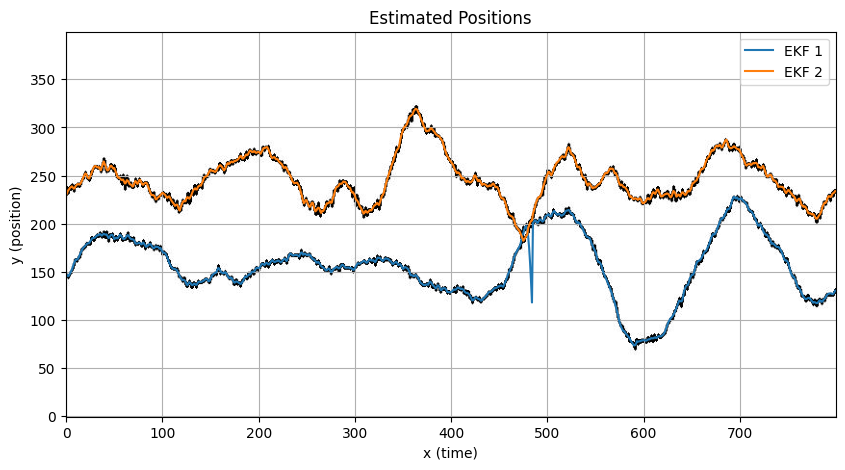

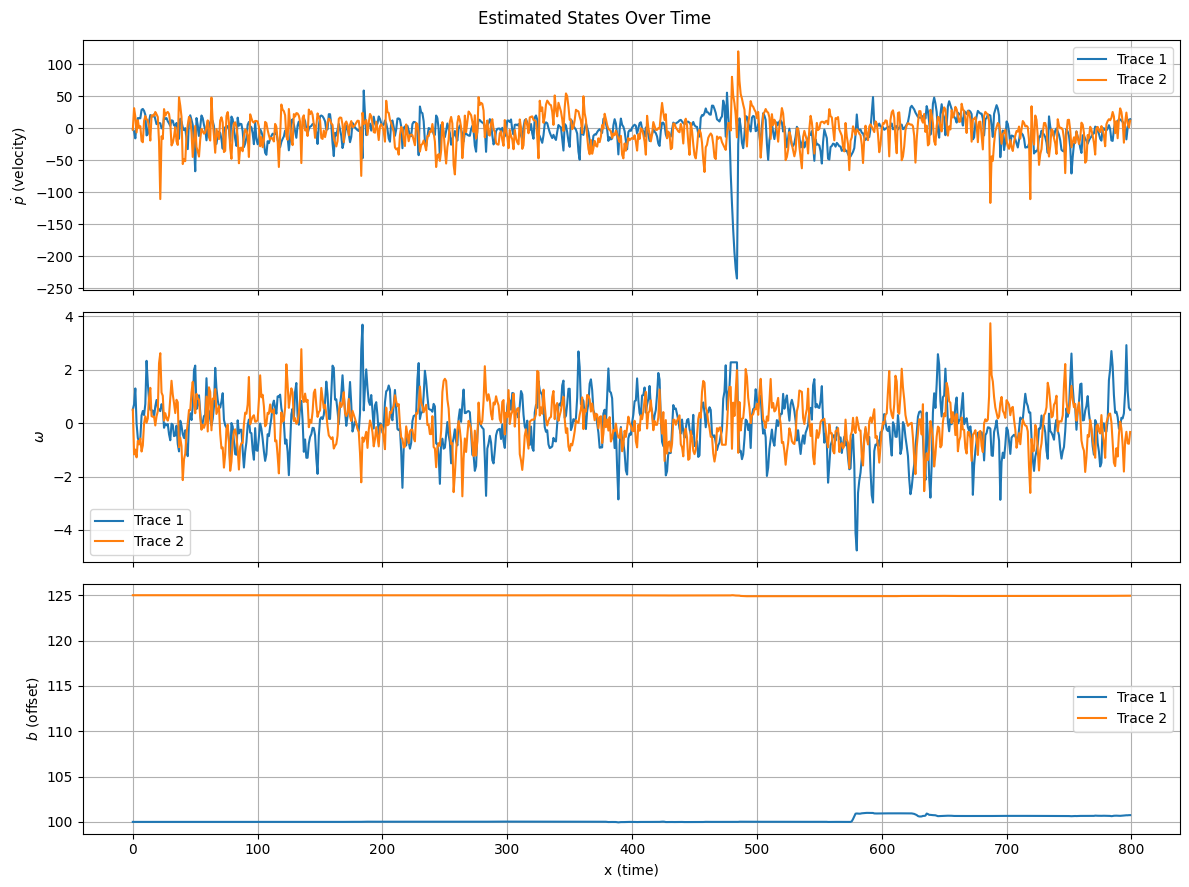

In [7]:
# Plot estimated positions
plt.figure(figsize=(12, 5))
plt.imshow(image.max() - image, cmap='gray', origin='lower')
for i in range(len(gt)):
    plt.plot(np.arange(image.shape[-1]), estimates[:, i], label=f'EKF {i+1}')
plt.legend()
plt.xlabel("x (time)")
plt.ylabel("y (position)")
plt.grid(True)
plt.title("Estimated Positions")
plt.show()

# Plot states: velocity, omega, offset
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
state_titles = [r"$\dot{p}$ (velocity)", r"$\omega$", r"$b$ (offset)"]
state_data = [velocities, frequencies, offsets]

for i, ax in enumerate(axs):
    for j in range(len(gt)):
        ax.plot(np.arange(image.shape[-1]), state_data[i][:, j], label=f'Trace {j+1}')
    ax.set_ylabel(state_titles[i])
    ax.legend()
    ax.grid(True)

axs[-1].set_xlabel("x (time)")
plt.suptitle("Estimated States Over Time")
plt.tight_layout()
plt.show()
